# DNN paper analysis
Analysis leading to the plots in [Distance-Based Delays in Echo State Networks](https://link.springer.com/chapter/10.1007/978-3-031-21753-1_21).

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import pandas as pd

## Functions
Some helper functions

In [179]:
def NARMA_plot_df_from_evo_dict(dict):
    val_score_mat = dict['validation performance']
    best_scores = []
    for pop in val_score_mat:
        ind_score = []
        for ind in pop:
            best_lag_score = []
            for rep in ind:
                best_lag_score.append(np.min(rep))
            ind_score.append(best_lag_score)
        best_scores.append(ind_score)
    best_scores = np.array(best_scores)
    best_i = np.argmin(np.average(best_scores, axis=-1), axis=-1)
    plot_data_dict = {
        'Generation':[],
        'NRMSE':[]
    }
    for g, i in enumerate(best_i):
        pop = best_scores[g, i, :]
        plot_data_dict['Generation'] += list(np.repeat(g, pop.shape))
        plot_data_dict['NRMSE'] += list(pop)

    plot_df = pd.DataFrame.from_dict(plot_data_dict)
    return plot_df

def get_lag_df(dict, gens):
    val_score_mat = dict['validation performance']
    pd_dict = {
        'Generation': [],
        'Lag': [],
        'NRMSE': []
    }
    for gen in gens:
        val_score = val_score_mat[gen, :, :, :]
        best_lags = np.mean(np.min(val_score, axis=-1))
        best_i = np.argmin(best_lags)
        best_val_score = val_score[best_i, :, :]
        for rep in best_val_score:
            pd_dict['Lag'] += list(range(len(rep)))
            pd_dict['Generation'] += len(rep) * [gen]
            pd_dict['NRMSE'] += list(rep)

    return pd.DataFrame.from_dict(pd_dict)

def get_lag_df_old(dict, gens):
    val_score_mat = dict['validation performance']
    pd_dict = {
        'Generation': [],
        'Lag': [],
        'NRMSE': []
    }
    for gen in gens:
        val_score = val_score_mat[gen, :, :, :]
        # val_score = np.mean(val_score, axis=1)
        val_score = np.mean(val_score, axis=0)
        for cand in val_score:
            pd_dict['Lag'] += list(range(len(cand)))
            pd_dict['Generation'] += len(cand) * [gen]
            pd_dict['NRMSE'] += list(cand)

    return pd.DataFrame.from_dict(pd_dict)

## Data import
First, the data paths and additional experiment info (missing from stored data pickles, but necessary for reproduction) is structured in a dict.

In [77]:
experiment_data = {
    '1K': {
        'DDN':
            {
                'path': 'results-2022-paper/cma_es_gmm_200222k1_tanh_vd_reg.p',
            },
        'ESN':
            {
                'path': 'results-2022-paper/cma_es_gmm_250322_k1_tanh_final_paper_bl.p',
            }
    },
    '4K': {
        'DDN':
            {
                'path': 'results-2022-paper/cma_es_gmm_230222k4_tanh_vd_reg.p',
            },
        'ESN':
            {
                'path': 'results-2022-paper/cma_es_gmm_230222k4_tanh_bl_reg.p',
            }
    }
}

In [78]:
for k_size in experiment_data:
    for net_type in experiment_data[k_size]:
        path = experiment_data[k_size][net_type]['path']
        with open(path, 'rb') as f:
            es_dict = pkl.load(f)
        print(es_dict.keys())
        experiment_data[k_size][net_type]['es_dict'] = es_dict

dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net'])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])


## Evolution Plots
validation score per generation for ESNs (baseline) and DDNs.


First, we process the Generations x Population size x Repetitions x Lag search space validation data matrix

In [79]:
for k_size in experiment_data:
    for net_type in experiment_data[k_size]:
        es_dict = experiment_data[k_size][net_type]['es_dict']
        validation_df = NARMA_plot_df_from_evo_dict(es_dict)
        experiment_data[k_size][net_type]['validation_df'] = validation_df

(0.0, 0.5)

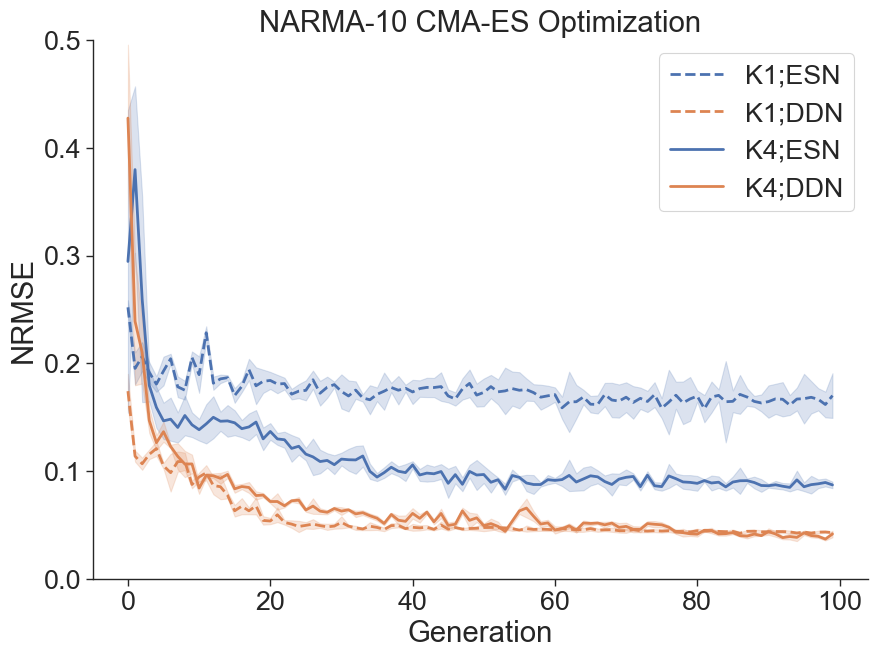

In [6]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=2.2, palette='deep', context='paper', rc=custom_params)

fig, ax= plt.subplots(figsize=(10,7))

sns.lineplot(experiment_data['1K']['ESN']['validation_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C0', linestyle="--", label="K1;ESN", errorbar='sd')
sns.lineplot(experiment_data['1K']['DDN']['validation_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C1', linestyle="--", label="K1;DDN", errorbar='sd')

sns.lineplot(experiment_data['4K']['ESN']['validation_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C0', linestyle="-", label="K4;ESN", errorbar='sd')
sns.lineplot(experiment_data['4K']['DDN']['validation_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C1', linestyle="-", label="K4;DDN", errorbar='sd')

plt.xlabel('Generation')
plt.ylabel('NRMSE')
ax.set_title("NARMA-10 CMA-ES Optimization")
ax.set_ylim(0, 0.5)


## Test data
Next cells are for analysis of best candidate test results that should be generated with [testOptimized.py](testOptimized.py).

First we load the results in a df

In [199]:
test_results_path = 'results-2022-paper/test_results/test_2025-02-26.p'
with open(test_results_path, 'rb') as f:
    test_dict = pkl.load(f)

y_label = 'NRMSE'
x_label = 'Clusters'
hue_label = 'Network Type'


pd_test_dict = {
    y_label: [],
    hue_label: [],
    x_label: []
}

for n_k in test_dict:
    for net_type in reversed(test_dict[n_k]):
        t = np.array(test_dict[n_k][net_type])
        t = np.min(t, axis=1)
        K = int(n_k[0])
        pd_test_dict[y_label] += list(t)
        pd_test_dict['Clusters'] += len(t) * [K]
        pd_test_dict['Network Type'] += len(t) * [net_type]

test_df = pd.DataFrame.from_dict(pd_test_dict)
test_df.head()

,NRMSE,Network Type,Clusters
0,0.134249,ESN,1
1,0.161834,ESN,1
2,0.153959,ESN,1
3,0.141652,ESN,1
4,0.150339,ESN,1


Summarize results in a point plot

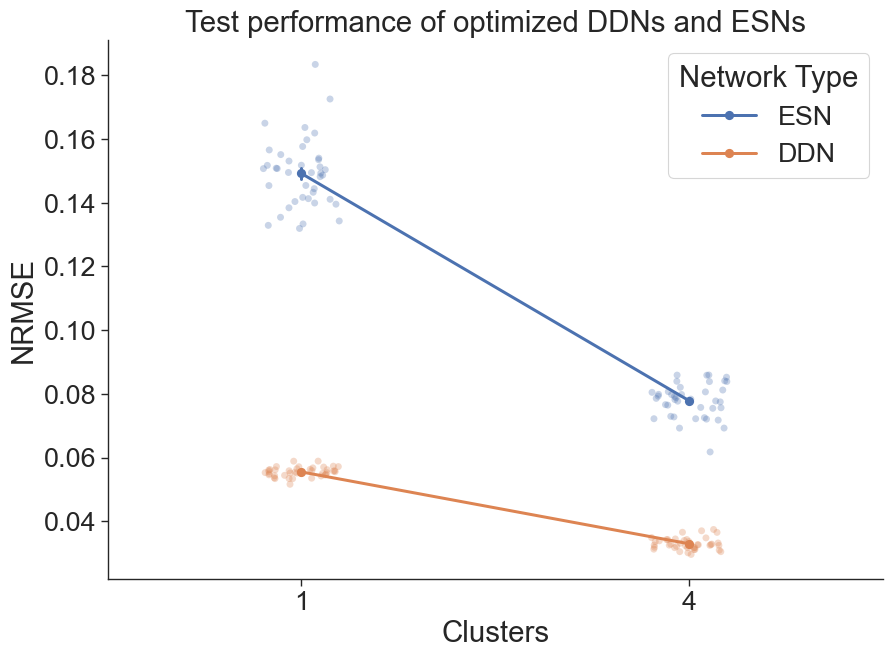

In [201]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=2.2, palette='deep', context='paper', rc=custom_params)

fig, ax= plt.subplots(figsize=(10,7))

sns.pointplot(test_df, x=x_label, y=y_label, hue=hue_label, errorbar='se', palette='deep', markers='o', markersize=5)

sns.stripplot(data=test_df, x=x_label, y=y_label, hue=hue_label, legend=False, alpha=0.3, palette='deep')

plt.title('Test performance of optimized DDNs and ESNs')
plt.savefig('figs_output/2022-interaction.pdf')

In [192]:
results_table_dict = {
    'Type' : [],
    'K': [],
    'NRMSE (test)': []
}

def bf_str(tab_str, best=False, math=False):
    if not best:
        return tab_str
    else:
        if math:
            tab_str = "$\mathbf{" + tab_str + "}$"
        else:
            tab_str = "\textbf{" + tab_str + "}"
        return tab_str

for type in ['ESN', 'DDN']:
    for k in [1, 4]:
        best = False
        if k == 4 and type == 'DDN':
            best = True
        k_key = str(k) + 'K'
        t = np.array(test_dict[k_key][type])
        t = np.min(t, axis=1)
        t_mean = np.mean(t)
        t_std = np.std(t)
        results_table_dict['Type'].append(bf_str(type, best, False))
        results_table_dict['K'].append(bf_str(str(k), best, False))
        nrmse_str = str(np.round(t_mean, 4)) + ' \pm ' + str(np.round(t_std, 4))
        nrmse_str = bf_str(nrmse_str, best, True)
        results_table_dict['NRMSE (test)'].append(nrmse_str)

results_summary_df = pd.DataFrame.from_dict(results_table_dict)

# export to latex table
results_latex = results_summary_df.to_latex(index=False, escape=False)
print(results_latex)

\begin{tabular}{lll}
\toprule
        Type &          K &                NRMSE (test) \\
\midrule
         ESN &          1 &           0.1491 \pm 0.0107 \\
         ESN &          4 &           0.0779 \pm 0.0053 \\
         DDN &          1 &           0.0555 \pm 0.0015 \\
\textbf{DDN} & \textbf{4} & $\mathbf{0.033 \pm 0.0018}$ \\
\bottomrule
\end{tabular}



C:\Users\stiac\AppData\Local\Temp\ipykernel_5644\1517006490.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results_latex = results_summary_df.to_latex(index=False, escape=False)


## Readout Lag behaviour
DDN response to input is slower than ESNs, requiring a lag in readout training to allow task input to reach the reservoir. Because it is not known how long exactly it takes for the input information to be maximally present in the reservoir, a gridsearch is performed over lag 0 to 15. Here I show NRMSE depends on lag throughout evolution.

In [181]:
gens = [0, 19, 39, 59, 79, 99]
for n_k in experiment_data:
    for net_type in experiment_data[n_k]:
        lag_df = get_lag_df_old(experiment_data[n_k][net_type]['es_dict'], gens)  # For reproducing 2022 paper
        # lag_df = get_lag_df(experiment_data[n_k][net_type]['es_dict'], gens)  # For non-averaged best candidate scores
        experiment_data[n_k][net_type]['lag_df'] = lag_df

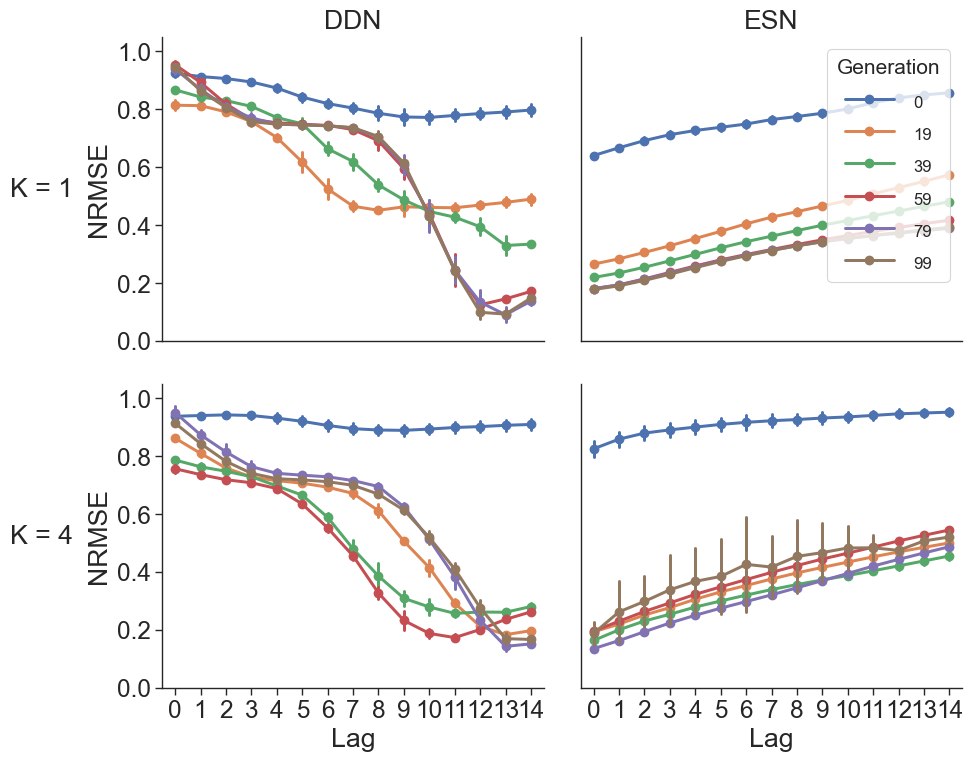

In [186]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper', rc=custom_params)

fig, ax= plt.subplots(2, 2, figsize=(10,8))
i_l = 0
j_l = 1

for i, n_k in enumerate(experiment_data):
    for j, net_type in enumerate(experiment_data[n_k]):
        lag_df = experiment_data[n_k][net_type]['lag_df']
        legend = False
        if i == i_l and j == j_l:
            legend = True
        sns.pointplot(lag_df, x='Lag', y='NRMSE', hue='Generation', ax=ax[i, j], errorbar='sd', legend=legend, palette='deep')
        ax[i,j].set_ylim(0, 1.05)
        if i == 0:
            ax[i,j].set_xlabel('')
            ax[i,j].set_xticks([])
            ax[i,j].set_title(net_type)
        if j > 0:
            ax[i,j].set_ylabel('')
            ax[i,j].set_yticks([])
        else:
            ax[i,j].text(-6.5, 0.5, "K = " + str(n_k[0]))
plt.tight_layout()
sns.move_legend(ax[i_l, j_l], "upper right")
plt.setp(ax[i_l, j_l].get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax[i_l, j_l].get_legend().get_title(), fontsize='15') # for legend title
plt.savefig('figs_output/lags-evo-2022.pdf')